0
1
1
0
1
1
1
1
1
1
[[ 0.  0. -1. -1.]
 [ 0.  1. -1.  0.]
 [-1. -1.  3. -1.]
 [-1.  0. -1.  2.]]
0
[0]
12
[0, 12]
[[1, 1, 1], [1, 1, 0]] [0, 12]


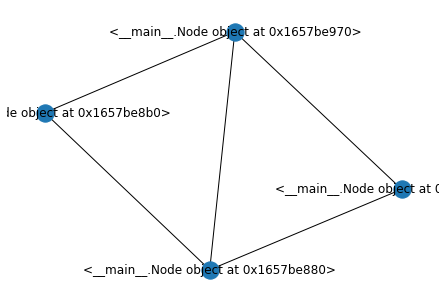

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def plotTraj(x, y, vx, vy, dt):
    g = 9.8
    t=0
    data  = []
    while y >= 0:
        ay = -g
        y += vy * dt    # use old vy to calculate new y
        vy += ay * dt   # use old ay to calculate new vy
        x += vx * dt
        t += dt
        #print(x, y, t)
        data.append({'x': x, 'y': y, 't': t})
    #print(data)
    df = pd.DataFrame(data)
    #print(df)
    df.plot(kind='scatter', x='x', y='y')
    plt.show()
    df.plot(kind='scatter', x='t', y='x')
    plt.show()
    df.plot(kind='scatter', x='t', y='y')
    plt.show()

class Node:
    v = 0
    

    def __init__(self, type='voltage'):
        self.type = type
        if(type=='gnd'):
            self.v=0
        elif(type=='voltage'):
            self.v=0



class Put:
    v = 0
    z = 0
    type = 'none'

    def __init__(self, type, impedence, value):
        if(type=='voltage'):
            self.v = value
            self.z = impedence
            self.type = 'voltage-source'
        elif(type=='current'):
            self.i = value
            self.z = impedence
            self.type = 'current-source'
        elif(type=='resistor'):
            self.z = impedence
            self.type = 'resistor'
        elif(type=='capacitor'):
            self.c = value
            self.z = impedence
            self.type = 'capacitor'
        elif(type=='inductor'):
            self.h = value
            self.z = impedence
            self.type = 'inductor'



node1 = Node('gnd')
node2 = Node()
node3 = Node()
node4 = Node()
put1 = Put('voltage', 0, 12)
put2 = Put('resistor', 1, 0)
put3 = Put('resistor', 1, 0)
put4 = Put('resistor', 1, 0)
put5 = Put('resistor', 1, 0)

G = nx.Graph()
G.add_nodes_from([node1, node2, node3, node4])
G.add_edge(node1, node2, put=put1)
G.add_edge(node2, node3, put=put2)
G.add_edge(node3, node1, put=put3)
G.add_edge(node3, node4, put=put4)
G.add_edge(node4, node1, put=put5)

#list(nx.connected_components(G))
#nx.clustering(G)
nx.draw(G, with_labels=True)

matrix = []
vs = []


node_count = len(list(G.nodes()))-1
v_s_count = 0
for edge in list(G.edges.data('put')):
    if(edge[2].type == 'voltage-source'):
        v_s_count = v_s_count + 1


addMat = np.zeros((node_count+v_s_count, node_count+v_s_count))

#print(list(G.edges.data('put'))[0][2].z)

for i, nodej in enumerate(G.nodes()):
    for j, nodek in enumerate(G.nodes()):
        if(i==j):
            if(nodej.type != 'gnd'):
                sum_cond = 0
                for edge in G.edges(nodej):
                    if(G[edge[0]][edge[1]]['put'].type=='resistor'):
                        sum_cond = sum_cond + 1/G[edge[0]][edge[1]]['put'].z
                addMat[i][j] = sum_cond
        elif(G.has_edge(nodej, nodek)):
            print(G[nodej][nodek]['put'].z)
            if(G[nodej][nodek]['put'].type=='resistor'):
                addMat[i][j] = -1/G[nodej][nodek]['put'].z
print(addMat)
        

    




def getSharedPuts(cycles):
    pair_list = []
    for i, cycle in enumerate(cycles):
        last_node = None
        pairs = []
        for j, node in enumerate(cycle):
            if(j==0):
                first_node = node
            elif(j==len(cycle)-1):
                pairs.append([last_node, node])
                pairs.append([node, first_node])
            else:
                pairs.append([last_node, node])
            last_node = node
        pair_list.append(pairs)
    for pair in pair_list[0]:
        #print(pair, pair_list[1])
        if pair in pair_list[1]:
            print('same', pair)
        if list(reversed(pair)) in pair_list[1]:
            print('reversed', pair)
    #print(pair_list)


cycles = nx.algorithms.cycles.cycle_basis(G, root=node1)
#print(cycles)
#getSharedPuts(cycles)

for i, cycle in enumerate(cycles):
    loop = []
    last_node = None
    first_node = None
    zs = []
    v=0
    for j, node in enumerate(cycle):
        if(j==0):
            first_node = node
        elif(j==len(cycle)-1):
            put =  G[last_node][node]['put']
            if(put.type == 'voltage-source'):
                #print(v)
                v = v+put.v
            elif(put.type == 'resistor'):
                zs.append(put.z)
            last_put = G[node][first_node]['put']
            if(last_put.type == 'voltage-source'):
                v = v+last_put.v
                zs.append(last_put.z)
                #print(v)
            elif(last_put.type == 'resistor'):
                zs.append(last_put.z)
        else: 
            put = G[last_node][node]['put']
            if(put.type == 'voltage-source'):
                v = v+put.v
                zs.append(put.z)
            elif(put.type == 'resistor'):
                zs.append(put.z)
        last_node = node
    print(v)
    vs.append(v)
    print(vs)
    matrix.append(zs)
print(matrix, vs)





